# 실습 목표: 무신사 리뷰 감성분석

## 1. 크롤링
  - 크롤링 대상 URL : https://www.musinsa.com/goods/reviews/lists
  - 수집하고 싶은 리뷰 사이트는 변경 가능 (올리브영, 네이버 쇼핑 등)
  - 필수 수집 데이터 (별점, 리뷰 텍스트)
  - 추가 수집 데이터 (상품정보나 유저 정보 등)

도전과제)  
scrapy 크롤링

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = '/content/drive/MyDrive/새싹2023/NLP/딥러닝/musinsa_review'

In [ ]:
with open(DATA_DIR, 'r', encoding='utf-8') as f:
    data = list(filter(lambda x : len(x)>1, [d.rstrip().split('spliter') for d in f.readlines()]))

print(len(data))

339147


In [ ]:
print(data[0])

['재질도 좋고 프린팅도 너무 맘에들어요 만족스럽습니다.', '5', '3', 'goods']


In [ ]:
ratings = set([d[-3] for d in data])

In [ ]:
ratings

{'1', '2', '3', '4', '5'}

## 2. 데이터 전처리
  - EDA (데이터 확인, 문장 길이 체크)
  - 감성분석 가능하도록 데이터 전처리 (텍스트, 라벨)
  - 사전학습 모델을 위한 tokenizer, input_transformer 정의
  - 데이터셋, 데이터로더 정의


In [ ]:
reviews = []
ratings = []
for review, rating, _, _ in data:
    rating = int(rating)
    if rating != 4: # 4 -> neutral
        # \t -> ' '로 변경
        reviews.append(review)
        ratings.append(1 if rating > 4 else 0) # 5 -> positive 1, 2, 3 -> negative

Counter({1: 295124, 0: 7847})


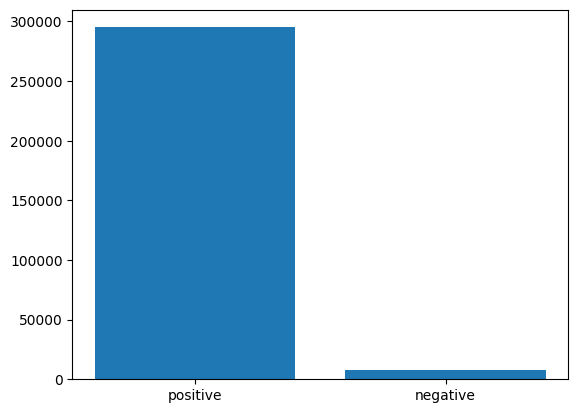

In [ ]:
from collections import Counter
print(Counter(ratings))

import matplotlib.pyplot as plt

# 데이터 불균형 심함
plt.bar(x=['positive', 'negative'], height=Counter(ratings).values())
plt.show()

1600 20 53.308811734456434


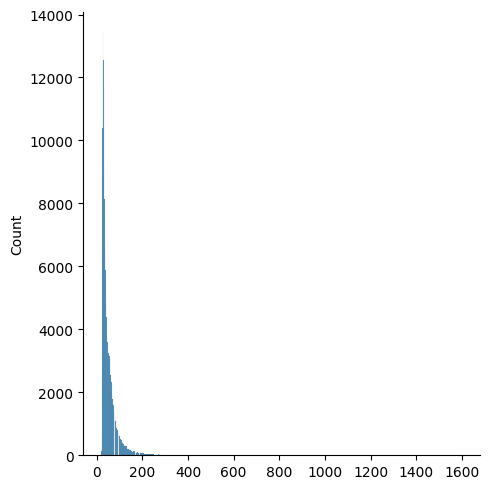

In [ ]:
import seaborn as sns
sent_length = list(map(len, reviews))
print(max(sent_length), min(sent_length), sum(sent_length)/len(sent_length))
sns.displot(sent_length)
plt.show()

In [ ]:
!wget https://raw.githubusercontent.com/monologg/KoBERT-Transformers/master/kobert_transformers/tokenization_kobert.py -O ./tokenization_kobert.py

--2023-08-22 05:42:29--  https://raw.githubusercontent.com/monologg/KoBERT-Transformers/master/kobert_transformers/tokenization_kobert.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10896 (11K) [text/plain]
Saving to: ‘./tokenization_kobert.py’

./tokenization_kobe 100%[===================>]  10.64K  --.-KB/s    in 0s      

2023-08-22 05:42:29 (91.9 MB/s) - ‘./tokenization_kobert.py’ saved [10896/10896]



In [ ]:
!pip3 install kobert-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.1 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from kobert_transformers import get_kobert_model, get_distilkobert_model
from tokenization_kobert import KoBertTokenizer

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

import numpy as np

In [ ]:
max_len = 128 # 문장 최대길이, EDA 필요
batch_size = 64

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
class InputTransformer:

    def __init__(self, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad_token = tokenizer.convert_tokens_to_ids(['[PAD]'])[0]

    def transform(self, sentences):
        # 성능개선필요 https://github.com/monologg/KoBERT-nsmc/blob/master/data_loader.py
        tokenized = [self.tokenizer.tokenize(sentence) for sentence in sentences]
        input_ids = [self.tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens + ['[SEP]'])[:self.max_len]
                     for tokens in tokenized]
        valid_lengths = [input_id.index(3) if len(input_id) < self.max_len else self.max_len for input_id in input_ids]
        token_ids = [np.array(input_id + [self.pad_token]*(self.max_len-valid_lengths[i]-1)) for i, input_id in enumerate(input_ids)]
        segment_ids = [np.zeros(self.max_len) for i in range(len(sentences))]

        return list(zip(token_ids, valid_lengths, segment_ids))


In [ ]:
class BERTDataset(Dataset):

    def __init__(self, transformer, sentences, labels=()):
        self.sentences = transformer.transform(sentences)
        self.is_test = False if labels else True
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, i):
        return self.sentences[i], self.labels[i] if not self.is_test else _

    def __len__(self):
        return len(self.sentences)


In [ ]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')
input_transformer = InputTransformer(tokenizer, max_len)

# train & test 데이터로 나누기
from sklearn.model_selection import train_test_split
trn_sents, valid_sents, trn_labels, valid_labels = train_test_split(reviews, ratings, test_size=0.25, random_state=0, stratify=ratings, shuffle=True)

# 검증셋은 라벨 불균형 고려대상 X
valid_dataset = BERTDataset(input_transformer, valid_sents, valid_labels)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=0)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


In [ ]:
Counter(trn_labels)

Counter({1: 221343, 0: 5885})

In [ ]:
pos_sents = []
neg_sents = []
for i, l in enumerate(trn_labels):
    if l:
        pos_sents.append(trn_sents[i])
    else:
        neg_sents.append(trn_sents[i])
print((len(pos_sents), len(neg_sents)))

# 임의로 샘플링 개수 설정 (학습 시 긍정 4800개 부정 4800개 랜덤추출하여 학습)
sample_count = 4800
import random
sample_pos = random.sample(pos_sents, sample_count)
sample_neg = random.sample(neg_sents, sample_count)

(221343, 5885)


In [ ]:
sample_sents, sample_labels = sample_pos+sample_neg, [1]*sample_count+[0]*sample_count

In [ ]:
# 학습 시 데이터 불균형 고려하여 데이터셋 생성 -> 학습 코드에서 샘플링, dataloader 생성
train_dataset = BERTDataset(input_transformer, sample_sents, sample_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)

## 3. 모델링
  - 사전학습 모델 선택, pretrained weight 가져오기
  - 모델 커스터마이징 (가져오는 모델에 따라서 num_labels를 수정하거나 linear layer 추가)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        self.classifier = nn.Linear(hidden_size , num_classes)

        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)

        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1

        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        # _, pooler = self.bert(input_ids = token_ids, # token_type_ids = segment_ids.long(),
        #                       attention_mask = attention_mask.to(token_ids.device), return_dict=False)

        # distilbert
        # input에서 token_type_ids가 빠짐 (NSP를 하지 않는다.)
        output = self.bert(input_ids = token_ids, # token_type_ids = segment_ids.long(),
                              attention_mask = attention_mask.to(token_ids.device), return_dict=False)
        pooler = output[0][:, 0] # (hidden_state, )

        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler

        return self.classifier(out)

# kobert = get_kobert_model()
distilbert = get_distilkobert_model()
model = BERTClassifier(distilbert, dr_rate=0.5).to(device)

## 4. 학습
  - 옵티마이저, 손실함수 지정
  - warmup scheduler 적용
  - 학습, 검증

In [ ]:
num_epochs = 10
learning_rate = 5e-5
warmup_ratio = 0.1
max_grad_norm = 1
log_interval = 30

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# 옵티마이저, 손실함수 지정
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()#.cuda()

t_total = len(train_loader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from tqdm.auto import tqdm

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return acc

In [ ]:
from copy import deepcopy

In [ ]:
loss_history = [] # 전체 loss
avg_loss_hisroty = [] # epoch별 평균 loss
test_history = [] # validation accuracy
test_loss_history = [] # epoch별 평균 validation loss

best_acc = 0.0
best_acc_model = deepcopy(model)
for e in range(num_epochs):
    total_loss=0.0
    train_acc = 0.0
    test_acc = 0.0
    test_total_loss=0.0

    # 학습데이터 epoch 마다 새로 샘플링
    sample_pos = random.sample(pos_sents, sample_count)
    sample_neg = random.sample(neg_sents, sample_count)
    sample_sents, sample_labels = sample_pos+sample_neg, [1]*sample_count+[0]*sample_count

    train_dataset = BERTDataset(input_transformer, sample_sents, sample_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)


    model.train() #훈련 선언
    for batch_id, ((token_ids, valid_length, segment_ids), label) in enumerate(tqdm(iter(train_loader))):
        optimizer.zero_grad()
        token_ids = token_ids.to(device)
        segment_ids = segment_ids.to(device)
        valid_length= valid_length
        label = label.to(device)
        out = model(token_ids, valid_length, segment_ids)

        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_acc += calc_accuracy(out, label)

        if (batch_id+1) % log_interval == 0:
            print("[train]\tepoch: {}\t batch id: {}/{}\t train_loss: {:.4f}\t train_acc: {:.4f}".format(e+1, batch_id+1,
                len(train_loader), loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            loss_history.append(loss.data.cpu().numpy())
            total_loss+=loss.data.cpu().numpy()

    avg_loss=total_loss/len(train_loader) #epoch별 평균 loss값
    avg_loss_hisroty.append(avg_loss)

    model.eval() #모델평가
    for batch_id, ((token_ids, valid_length, segment_ids), label) in enumerate(tqdm(iter(valid_loader))):
        token_ids = token_ids.to(device)
        segment_ids = segment_ids.to(device)
        valid_length= valid_length
        label = label.to(device)
        with torch.no_grad():
            out = model(token_ids, valid_length, segment_ids)
            loss = loss_fn(out, label).detach()
            test_acc += calc_accuracy(out, label)
            test_total_loss += loss.data.cpu().numpy()
        test_history.append(test_acc / (batch_id+1))

    test_avg_loss=test_total_loss/len(valid_loader)
    test_loss_history.append(test_avg_loss)
    print("[valid]\tepoch: {}\t valid loss: {:.4f}\t valid acc: {:.4f}".format(e+1, test_avg_loss,
        test_acc/len(valid_loader)))

    if (test_acc / (batch_id+1)) > best_acc:
          best_acc = (test_acc / (batch_id+1))
          best_acc_model = deepcopy(model)


  0%|          | 0/150 [00:00<?, ?it/s]

[train]	epoch: 1	 batch id: 30/150	 train_loss: 0.7112	 train_acc: 0.5203
[train]	epoch: 1	 batch id: 60/150	 train_loss: 0.6672	 train_acc: 0.5339
[train]	epoch: 1	 batch id: 90/150	 train_loss: 0.6154	 train_acc: 0.5766
[train]	epoch: 1	 batch id: 120/150	 train_loss: 0.5056	 train_acc: 0.6142
[train]	epoch: 1	 batch id: 150/150	 train_loss: 0.5251	 train_acc: 0.6442


  0%|          | 0/1184 [00:00<?, ?it/s]

[valid]	epoch: 1	 valid loss: 0.5745	 valid acc: 0.7479


  0%|          | 0/150 [00:00<?, ?it/s]

[train]	epoch: 2	 batch id: 30/150	 train_loss: 0.4197	 train_acc: 0.7901
[train]	epoch: 2	 batch id: 60/150	 train_loss: 0.5380	 train_acc: 0.7896
[train]	epoch: 2	 batch id: 90/150	 train_loss: 0.5249	 train_acc: 0.7918
[train]	epoch: 2	 batch id: 120/150	 train_loss: 0.3975	 train_acc: 0.7871
[train]	epoch: 2	 batch id: 150/150	 train_loss: 0.4505	 train_acc: 0.7882


  0%|          | 0/1184 [00:00<?, ?it/s]

[valid]	epoch: 2	 valid loss: 0.4838	 valid acc: 0.8141


  0%|          | 0/150 [00:00<?, ?it/s]

[train]	epoch: 3	 batch id: 30/150	 train_loss: 0.4845	 train_acc: 0.7995
[train]	epoch: 3	 batch id: 60/150	 train_loss: 0.3013	 train_acc: 0.8109
[train]	epoch: 3	 batch id: 90/150	 train_loss: 0.4174	 train_acc: 0.8087
[train]	epoch: 3	 batch id: 120/150	 train_loss: 0.4036	 train_acc: 0.8130
[train]	epoch: 3	 batch id: 150/150	 train_loss: 0.4867	 train_acc: 0.8140


  0%|          | 0/1184 [00:00<?, ?it/s]

[valid]	epoch: 3	 valid loss: 0.3900	 valid acc: 0.8584


  0%|          | 0/150 [00:00<?, ?it/s]

[train]	epoch: 4	 batch id: 30/150	 train_loss: 0.5413	 train_acc: 0.8385
[train]	epoch: 4	 batch id: 60/150	 train_loss: 0.3885	 train_acc: 0.8279
[train]	epoch: 4	 batch id: 90/150	 train_loss: 0.4610	 train_acc: 0.8238
[train]	epoch: 4	 batch id: 120/150	 train_loss: 0.4255	 train_acc: 0.8232
[train]	epoch: 4	 batch id: 150/150	 train_loss: 0.3682	 train_acc: 0.8257


  0%|          | 0/1184 [00:00<?, ?it/s]

[valid]	epoch: 4	 valid loss: 0.3424	 valid acc: 0.8753


  0%|          | 0/150 [00:00<?, ?it/s]

[train]	epoch: 5	 batch id: 30/150	 train_loss: 0.3031	 train_acc: 0.8349
[train]	epoch: 5	 batch id: 60/150	 train_loss: 0.2319	 train_acc: 0.8393
[train]	epoch: 5	 batch id: 90/150	 train_loss: 0.4377	 train_acc: 0.8332
[train]	epoch: 5	 batch id: 120/150	 train_loss: 0.4025	 train_acc: 0.8303
[train]	epoch: 5	 batch id: 150/150	 train_loss: 0.3608	 train_acc: 0.8318


  0%|          | 0/1184 [00:00<?, ?it/s]

[valid]	epoch: 5	 valid loss: 0.2901	 valid acc: 0.9035


  0%|          | 0/150 [00:00<?, ?it/s]

[train]	epoch: 6	 batch id: 30/150	 train_loss: 0.3537	 train_acc: 0.8453
[train]	epoch: 6	 batch id: 60/150	 train_loss: 0.5041	 train_acc: 0.8448
[train]	epoch: 6	 batch id: 90/150	 train_loss: 0.2609	 train_acc: 0.8484
[train]	epoch: 6	 batch id: 120/150	 train_loss: 0.2656	 train_acc: 0.8504
[train]	epoch: 6	 batch id: 150/150	 train_loss: 0.4116	 train_acc: 0.8515


  0%|          | 0/1184 [00:00<?, ?it/s]

[valid]	epoch: 6	 valid loss: 0.3473	 valid acc: 0.8762


  0%|          | 0/150 [00:00<?, ?it/s]

[train]	epoch: 7	 batch id: 30/150	 train_loss: 0.2830	 train_acc: 0.8609
[train]	epoch: 7	 batch id: 60/150	 train_loss: 0.4178	 train_acc: 0.8625
[train]	epoch: 7	 batch id: 90/150	 train_loss: 0.3890	 train_acc: 0.8592
[train]	epoch: 7	 batch id: 120/150	 train_loss: 0.3140	 train_acc: 0.8556
[train]	epoch: 7	 batch id: 150/150	 train_loss: 0.3831	 train_acc: 0.8561


  0%|          | 0/1184 [00:00<?, ?it/s]

[valid]	epoch: 7	 valid loss: 0.3173	 valid acc: 0.8853


  0%|          | 0/150 [00:00<?, ?it/s]

[train]	epoch: 8	 batch id: 30/150	 train_loss: 0.4098	 train_acc: 0.8641
[train]	epoch: 8	 batch id: 60/150	 train_loss: 0.2477	 train_acc: 0.8568
[train]	epoch: 8	 batch id: 90/150	 train_loss: 0.5006	 train_acc: 0.8557
[train]	epoch: 8	 batch id: 120/150	 train_loss: 0.3756	 train_acc: 0.8572
[train]	epoch: 8	 batch id: 150/150	 train_loss: 0.3104	 train_acc: 0.8544


  0%|          | 0/1184 [00:00<?, ?it/s]

[valid]	epoch: 8	 valid loss: 0.3686	 valid acc: 0.8617


  0%|          | 0/150 [00:00<?, ?it/s]

[train]	epoch: 9	 batch id: 30/150	 train_loss: 0.4203	 train_acc: 0.8490
[train]	epoch: 9	 batch id: 60/150	 train_loss: 0.1508	 train_acc: 0.8549
[train]	epoch: 9	 batch id: 90/150	 train_loss: 0.4076	 train_acc: 0.8576
[train]	epoch: 9	 batch id: 120/150	 train_loss: 0.3182	 train_acc: 0.8560
[train]	epoch: 9	 batch id: 150/150	 train_loss: 0.3015	 train_acc: 0.8594


  0%|          | 0/1184 [00:00<?, ?it/s]

[valid]	epoch: 9	 valid loss: 0.3547	 valid acc: 0.8687


  0%|          | 0/150 [00:00<?, ?it/s]

[train]	epoch: 10	 batch id: 30/150	 train_loss: 0.2506	 train_acc: 0.8542
[train]	epoch: 10	 batch id: 60/150	 train_loss: 0.3132	 train_acc: 0.8534
[train]	epoch: 10	 batch id: 90/150	 train_loss: 0.3404	 train_acc: 0.8554
[train]	epoch: 10	 batch id: 120/150	 train_loss: 0.2419	 train_acc: 0.8573
[train]	epoch: 10	 batch id: 150/150	 train_loss: 0.2824	 train_acc: 0.8591


  0%|          | 0/1184 [00:00<?, ?it/s]

[valid]	epoch: 10	 valid loss: 0.3259	 valid acc: 0.8815


## 5. 예측
  - 새로운 리뷰 데이터셋에 대하여 예측 (테스트셋)
  - predict 함수 정의 (문장 -> 라벨 반환)

In [ ]:
# parameter를 test_sentences로 받기
def predict(model, test_sentences, test_labels, device):
    # dataset, dataloader 정의
    pred_dataset = BERTDataset(input_transformer, test_sentences, test_labels)
    test_loader = torch.utils.data.DataLoader(pred_dataset, batch_size=batch_size, num_workers=0)

    model.eval() # gpu
    test_loss = 0.0
    test_acc = 0.0
    preds = torch.tensor([], dtype=torch.long) # cpu
    for (token_ids, valid_length, segment_ids), label in test_loader:
        token_ids = token_ids.to(device)
        segment_ids = segment_ids.to(device)
        valid_length = valid_length
        label = label.to(device)

        with torch.no_grad():
            out = model(token_ids, valid_length, segment_ids) # gpu
            loss = loss_fn(out, label).detach()
            test_acc += calc_accuracy(out, label)
            test_loss += loss.data.cpu().numpy()
            # print(out.shape) # batch_size, output (64, 2)
            pred = torch.argmax(out, dim=1) # (64, ) # gpu
            # out에 argmax 적용 (긍정, 부정 라벨 체크)
            # torch.cat (데이터 개수만큼 concat)
            preds = torch.cat([preds, pred.detach().cpu()])
    print(preds)

    preds = ['긍정' if pred == 1 else '부정' for pred in preds]
    print(test_loss/len(test_loader), test_acc/len(test_loader))
    return list(zip(test_sentences, preds)) # (1:1로 묶어서 반환)

In [ ]:
predict(model, valid_sents[:256], valid_labels[:256], device)

In [ ]:
DATA_DIR

'/content/drive/MyDrive/새싹2023/NLP/딥러닝/musinsa_review'

In [ ]:
torch.save(best_acc_model.state_dict(), DATA_DIR.replace('musinsa_review', '') +'best_model.pt')

In [ ]:
MODEL_DIR = DATA_DIR.replace('musinsa_review', '') +'best_model.pt'

In [ ]:
model.load_state_dict(torch.load(MODEL_DIR))

<All keys matched successfully>